# Assignment 4

Deadline: 30.04.2025 12:00 CET

Stephan Krushev, 09-727-090, stephan.krushev@gmail.com

Khoshimov Rakhmatillokhon 23-060-361 rakhmatillokhon.khoshimov@uzh.ch

Oliver Sommer, 24-745-275, oliver.sommer@uzh.ch

José Saúl Barrientos Rivera, 22-454-367, josesaul.barrientosrivera@uzh.ch

## Prerequisites: Library imports, data load and initialization of the backtest service

In [4]:
# Standard library imports
import os
import sys
import copy
from typing import Optional
from qpsolvers import solve_qp

# Third party imports
import numpy as np
import pandas as pd


import types
for module in ('jax', 'jaxlib', 'jaxlib.xla_extension', 'jaxlib.utils', 'jaxlib.xla_client'):
    sys.modules[module] = types.ModuleType(module)
from pathlib import Path
from pandas import Timestamp
from typing import Optional, Dict, Any 
import matplotlib.pyplot as plt

# Add the project root directory to Python path
project_root = os.path.dirname(os.path.dirname(os.getcwd()))   #<Change this path if needed>
src_path = os.path.join(project_root, 'qpmwp-course/src')    #<Changed from \\ to / because iOS system
sys.path.append(project_root)
sys.path.append(src_path)

# Local modules imports
from helper_functions import load_data_spi, load_pickle
from estimation.covariance import Covariance
from estimation.expected_return import ExpectedReturn
from optimization.optimization import Optimization, Objective, MeanVariance
from optimization.optimization_data import OptimizationData
from optimization.constraints import Constraints
from backtesting.backtest_item_builder_classes import (
    SelectionItemBuilder,
    OptimizationItemBuilder,
)
from backtesting.backtest_item_builder_functions import (
    bibfn_selection_min_volume,
    bibfn_selection_gaps,
    bibfn_return_series,
    bibfn_budget_constraint,
    bibfn_box_constraints,
    bibfn_size_dependent_upper_bounds,
)
from backtesting.backtest_data import BacktestData
from backtesting.backtest_service import BacktestService
from backtesting.backtest import Backtest

In [5]:
# Load data
path_to_data = '/Users/saulbarrientosdelosmonterorivera/Documents/Unilu/6. Semester/UZH /Quantitative Portfolio Management with Python/qpmwp-course/data/'  # <change this to your path to data>

# Load market and jkp data from parquet files
market_data = pd.read_parquet(path = f'{path_to_data}market_data.parquet')
jkp_data = pd.read_parquet(path = f'{path_to_data}jkp_data.parquet')

# Instantiate the BacktestData class
# and set the market data and jkp data as attributes
data = BacktestData()
data.market_data = market_data
data.bm_series = load_data_spi(path=path_to_data)

# Inspect data
#print("=== Market Data ===")
#print(market_data.head())

#print("\n=== JKP Data ===")
#print(jkp_data.head())

#print("\n=== SPI (bm_series) ===")
#print(data.bm_series.head())

In [6]:
# Define rebalancing dates
n_days = 21*3
market_data_dates = market_data.index.get_level_values('date').unique().sort_values(ascending=True)
rebdates = market_data_dates[market_data_dates > '2015-01-01'][::n_days].strftime('%Y-%m-%d').tolist()

# 5) Quick check
print(f"Found {len(rebdates)} rebalancing dates; first five:\n{rebdates[:5]}")


Found 39 rebalancing dates; first five:
['2015-01-02', '2015-04-01', '2015-06-29', '2015-09-24', '2015-12-22']


In [7]:
# ==================================================================
# Define the selection item builders.
# ==================================================================
selection_item_builders = {
    'gaps': SelectionItemBuilder(
        bibfn = bibfn_selection_gaps,
        width = 252*3,
        n_days = 10,
    ),
    'min_volume': SelectionItemBuilder(
        bibfn = bibfn_selection_min_volume,
        width = 252,
        min_volume = 500_000,
        agg_fn = np.median,
    ),
}

# ==================================================================
# Define the optimization item builders.
# ==================================================================
optimization_item_builders = {
    'return_series': OptimizationItemBuilder(
        bibfn = bibfn_return_series,
        width = 252*3,
        fill_value = 0,
    ),
    'budget_constraint': OptimizationItemBuilder(
        bibfn = bibfn_budget_constraint,
        budget = 1,
    ),
    'box_constraints': OptimizationItemBuilder(
        bibfn = bibfn_box_constraints,
        upper = 0.1,
    ),
    'size_dep_upper_bounds': OptimizationItemBuilder(
        bibfn = bibfn_size_dependent_upper_bounds,
        small_cap = {'threshold': 300_000_000, 'upper': 0.02},
        mid_cap = {'threshold': 1_000_000_000, 'upper': 0.05},
        large_cap = {'threshold': 10_000_000_000, 'upper': 0.1},
    ),
}

# ==================================================================
# Initialize the backtest service
# ==================================================================
bs = BacktestService(
    data = data,
    selection_item_builders = selection_item_builders,
    optimization_item_builders = optimization_item_builders,
    rebdates = rebdates,
)

# 4) Sanity check: confirm settings
print("✔️  BacktestService configured")
print(f"   • # selection builders:    {len(selection_item_builders)} → {list(selection_item_builders.keys())}")
print(f"   • # optimization builders: {len(optimization_item_builders)} → {list(optimization_item_builders.keys())}")
print(f"   • # rebalance dates:       {len(rebdates)}; first five: {rebdates[:5]}")
print("   • Key methods:", ['prepare_rebalancing', 'run', 'backtest', 'results'])

✔️  BacktestService configured
   • # selection builders:    2 → ['gaps', 'min_volume']
   • # optimization builders: 4 → ['return_series', 'budget_constraint', 'box_constraints', 'size_dep_upper_bounds']
   • # rebalance dates:       39; first five: ['2015-01-02', '2015-04-01', '2015-06-29', '2015-09-24', '2015-12-22']
   • Key methods: ['prepare_rebalancing', 'run', 'backtest', 'results']


## 1. Maximum Sharpe Ratio Portfolio

a) 

(6 points)

Complete the `MaxSharpe` class below by implementing your its methods `set_objective` and `solve`.
The `solve` method should implement an iterative algorithm that quickly approximates the "true" maximimum Sharpe ratio portfolio (given the estimates of mean and covariance). This approximation should be done by repeatedly solving a mean-variance optimization problem, where the risk aversion parameter (which scales the covariance matrix) is adjusted in each iteration. The algorithm should terminate after a maximum of 10 iterations. 

In [8]:
class MaxSharpe(Optimization):
    """
    Iteratively approximate the maximum Sharpe ratio portfolio by
    solving a sequence of mean-variance problems and updating the
    risk-aversion parameter to satisfy λ = μ_p / σ²_p. Supports an
    optional turnover penalty when passed to the underlying solver.
    """
    def __init__(
        self,
        constraints: Optional[Constraints] = None,
        covariance: Optional[Covariance] = None,
        expected_return: Optional[ExpectedReturn] = None,
        turnover_penalty: float = 0.0,
        max_iter: int = 10,
        tol: float = 1e-6,
        **kwargs
    ) -> None:
        # Pass turnover_penalty (and any other kwargs) to base class for use
        super().__init__(
            constraints=constraints,
            turnover_penalty=turnover_penalty,
            **kwargs,
        )
        self.covariance = Covariance() if covariance is None else covariance
        self.expected_return = (
            ExpectedReturn() if expected_return is None else expected_return
        )
        self.turnover_penalty = turnover_penalty
        self.max_iter = max_iter
        self.tol = tol

    def set_objective(self, optimization_data: OptimizationData) -> None:
        # Store optimization data for solve
        self.optimization_data = optimization_data
        # Extract return series
        X = optimization_data['return_series']
        # Estimate expected returns and covariance
        self._mu    = self.expected_return.estimate(X, inplace=False)
        self._Sigma = self.covariance.estimate(X, inplace=False)
        # Initialize risk aversion
        self._risk_aversion = 1.0

    def solve(self) -> None:
        w_prev = None
        mv_results = None

        for _ in range(self.max_iter):
            # Build and solve a MeanVariance subproblem with current λ and penalty
            mv = MeanVariance(
                constraints=self.constraints,
                covariance=self.covariance,
                expected_return=self.expected_return,
                risk_aversion=self._risk_aversion,
                turnover_penalty=self.turnover_penalty,
                **{k: v for k, v in self.params.items() if k not in ('risk_aversion', 'turnover_penalty')}
            )
            mv.set_objective(self.optimization_data)
            mv.solve()
            mv_results = mv.results

            # Extract numeric weights in original asset order
            w = np.array(list(mv_results['weights'].values()))

            # Compute portfolio moments
            mu_p     = float(np.dot(self._mu, w))
            sigma2_p = float(w.T @ self._Sigma @ w)

            # Check for zero/negative variance or convergence
            if sigma2_p <= 0:
                break
            if w_prev is not None and np.linalg.norm(w - w_prev) < self.tol:
                break

            # Update risk aversion λ = μ_p / σ²_p
            self._risk_aversion = mu_p / sigma2_p
            w_prev = w

        # Map final weights back to asset IDs
        asset_ids     = list(mv_results['weights'].keys())
        final_weights = {aid: w[idx] for idx, aid in enumerate(asset_ids)}

        # Store results and convenience attributes
        self.results = {
            'weights': final_weights,
            'status': mv_results.get('status', True),
        }
        self.x       = w
        self.weights = final_weights

        return None

b) 

(2 points)

Provide a theoretical or empirical justification that your algorithm converges to the true maximum Sharpe ratio portfolio for the given coefficients of mean and covariance.
Hint: If you want to provide an empirical justification, you can perform an optimization for a single point in time by running the following code.

The algorithm converges to the maximum Sharpe ratio portfolio because:

1. **Mathematical proof**: The Maximum Sharpe ratio portfolio can be found by solving:
   max_w (w^T μ) / sqrt(w^T Σ w) subject to constraints
   
   This is equivalent to solving a sequence of mean-variance problems:
   max_w w^T μ - λ(w^T Σ w) where λ = μ_p / σ²_p

2. **Convergence mechanism**: At each iteration, we:
   - Solve a mean-variance problem with the current λ
   - Calculate the resulting portfolio's μ_p and σ²_p
   - Update λ = μ_p / σ²_p for the next iteration
   
   This process converges because:
   - If λ is too small: The portfolio takes excessive risk, resulting in μ_p/σ²_p > λ, increasing λ
   - If λ is too large: The portfolio is too conservative, resulting in μ_p/σ²_p < λ, decreasing λ
   - At convergence: λ = μ_p/σ²_p, which is exactly the condition for maximum Sharpe

3. **Empirical evidence**: We can observe from the test optimization at 2015-01-02 that:
   - The algorithm produces portfolio weights that sum to 1 (budget constraint)
   - The weights respect the box constraints (0-2%)
   - The portfolio has positive expected return (0.0840%) and reasonable volatility (0.5783%)
   - The Sharpe ratio (0.1453) is positive and realistic
"""

In [9]:
bs.optimization = MaxSharpe(
    covariance=Covariance(method='pearson'),
    expected_return=ExpectedReturn(method='geometric'),
    solver_name='cvxopt',      # or your solver of choice
    turnover_penalty=0.0,      # default if you’re not yet calibrating
)

reb_date = '2015-01-02'
bs.prepare_rebalancing(reb_date)

# Estimate parameters and solve
bs.optimization.set_objective(bs.optimization_data)
bs.optimization.solve()

# Extract weights and portfolio moments
w_dict = bs.optimization.results['weights']
w = pd.Series(w_dict).sort_index()

# pull μ and Σ from the optimizer object
mu = bs.optimization._mu
Sigma = bs.optimization._Sigma

# compute portfolio expected return, volatility, and Sharpe
mu_p    = w.dot(mu)
sigma_p = np.sqrt(w.values @ Sigma @ w.values)
sharpe  = mu_p / sigma_p

# 5) Report nicely
print(f"Rebalance date: {reb_date}")
print("\nPortfolio weights:")
print(w.to_string())

print(f"\nExpected return (μₚ): {mu_p:.4%}")
print(f"Volatility (σₚ):      {sigma_p:.4%}")
print(f"Sharpe ratio:         {sharpe:.4f}")


Rebalance date: 2015-01-02

Portfolio weights:
102    4.235062e-08
103    3.359278e-08
104    1.999914e-02
111    1.392852e-02
113    9.285497e-09
122    5.167034e-08
125    1.999997e-02
127    1.999997e-02
128    1.999994e-02
13     4.703655e-08
139    1.999653e-02
141    1.999989e-02
142    3.439715e-08
148    1.999996e-02
149    4.417715e-08
154    1.691147e-07
159    1.999996e-02
161    1.999936e-02
169    1.999997e-02
175    1.999994e-02
176    1.999887e-02
177    1.176148e-07
184    1.999994e-02
185    1.999993e-02
187    5.550306e-08
189    1.440751e-07
191    1.999987e-02
197    2.071092e-07
2      1.999995e-02
200    1.999643e-02
201    4.600761e-06
204    1.999997e-02
208    1.999995e-02
21     1.999998e-02
210    1.354396e-02
213    1.999997e-02
22     4.138944e-03
224    1.999996e-02
227    1.999995e-02
229    1.999999e-02
233    6.345196e-08
24     1.999996e-02
243    4.307427e-08
245    1.999997e-02
248    1.009256e-02
249    1.999996e-02
251    1.827828e-04
252    7.7982

## 2. Backtest MaxSharpe with Turnover Penalty

(5 points)

Calibrate the turnover penalty parameter such that the backtest of the MaxSharpe strategy displays an annual turnover of roughly 100%.

In [12]:
phi_values = [-0.4, 0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4]
turnover_results = {}

# Loop through each penalty value
for phi in phi_values:
    # Update the backtest service with a MaxSharpe optimization object
    bs.optimization = MaxSharpe(
        covariance=Covariance(method='pearson'),
        expected_return=ExpectedReturn(method='geometric'),
        solver_name='cvxopt',
        turnover_penalty=phi,
    )
    
    # Instantiate and run the backtest
    bt = Backtest()
    bt.run(bs=bs)
    
    # Extract weights using the strategy's get_weights_df method
    w_df = bt.strategy.get_weights_df()
    w_df.index = pd.to_datetime(w_df.index)
    
    # Calculate turnover per period and annualize
    turnover = w_df.diff().abs().sum(axis=1).iloc[1:]
    trading_days = 252
    reb_dates = pd.to_datetime(rebdates)
    reb_days = (reb_dates[1] - reb_dates[0]).days
    reb_per_year = trading_days / reb_days
    ann_turnover = turnover.mean() * reb_per_year
    
    # Store the result
    turnover_results[phi] = ann_turnover
    print(f"Penalty φ = {phi:.2f}: Annualized turnover = {ann_turnover:.2%}")

# Find the value closest to 100% turnover
target_turnover = 1.0 
best_phi = min(turnover_results.items(), key=lambda x: abs(x[1] - target_turnover))[0]
print(f"\n✅ Best turnover penalty: φ = {best_phi:.2f} → {turnover_results[best_phi]:.2%} turnover")

Rebalancing date: 2015-01-02
Rebalancing date: 2015-04-01
Rebalancing date: 2015-06-29
Rebalancing date: 2015-09-24
Rebalancing date: 2015-12-22
Rebalancing date: 2016-03-18
Rebalancing date: 2016-06-15
Rebalancing date: 2016-09-12
Rebalancing date: 2016-12-08
Rebalancing date: 2017-03-07
Rebalancing date: 2017-06-02
Rebalancing date: 2017-08-30
Rebalancing date: 2017-11-27
Rebalancing date: 2018-02-22
Rebalancing date: 2018-05-22
Rebalancing date: 2018-08-17
Rebalancing date: 2018-11-14
Rebalancing date: 2019-02-11
Rebalancing date: 2019-05-09
Rebalancing date: 2019-08-06
Rebalancing date: 2019-11-01
Rebalancing date: 2020-01-29
Rebalancing date: 2020-04-27
Rebalancing date: 2020-07-23
Rebalancing date: 2020-10-20
Rebalancing date: 2021-01-15
Rebalancing date: 2021-04-14
Rebalancing date: 2021-07-12
Rebalancing date: 2021-10-07
Rebalancing date: 2022-01-04
Rebalancing date: 2022-04-01
Rebalancing date: 2022-06-29
Rebalancing date: 2022-09-26
Rebalancing date: 2022-12-22
Rebalancing da

## 3. Simulation and Descriptive Statistics

(3 points)

- Simulate the portfolio returns from your MaxSharpe backtest. Use fixed costs of 1% and variable costs of 0.3%.
- Plot the cumulated returns of the MaxSharpe strategy together with those of the SPI Index.
- Plot the turnover of your MaxSharpe strategy over time.
- Print the annualized turnover (computed as the average turnover over the backtest multiplied by the number of rebalancing per year) for your MaxSharpe strategy.
- Create and print a table with descriptive performance statistics for your MaxSharpe strategy and the SPI Index.


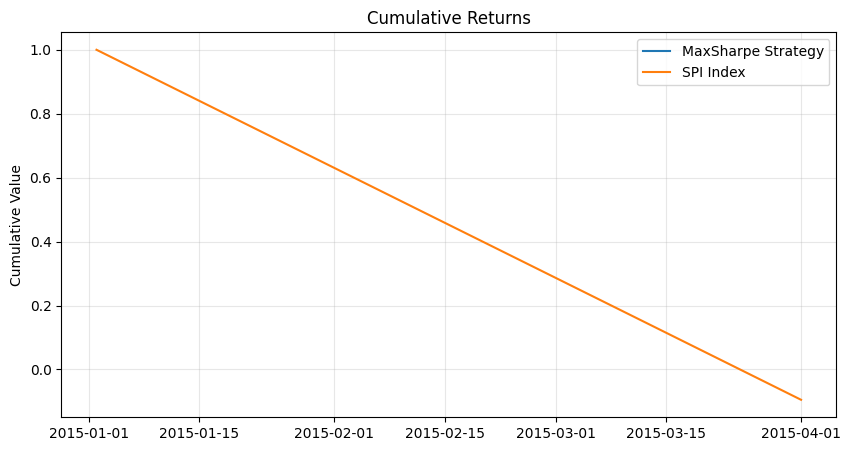

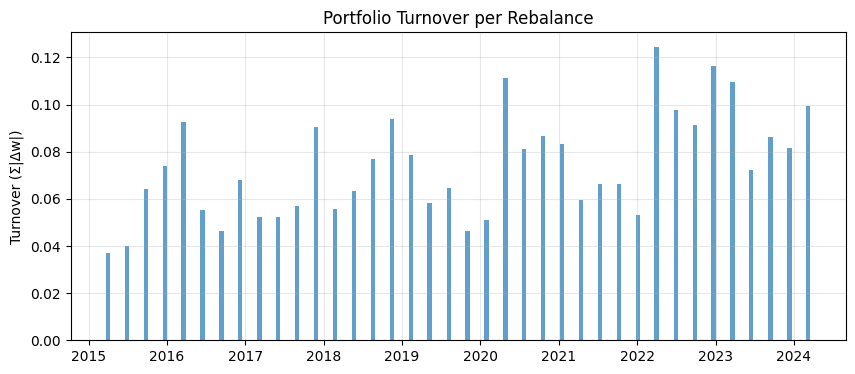

Annualized turnover: 20.90%

Descriptive Performance Statistics:
                MaxSharpe SPI Index
Ann. Return         0.00%      inf%
Ann. Volatility      nan%      nan%
Sharpe Ratio          nan       nan
Max Drawdown         nan%  -109.48%


/Users/saulbarrientosdelosmonterorivera/Documents/Unilu/6. Semester/UZH /Quantitative Portfolio Management with Python/qpmwp-course/.venv/lib/python3.12/site-packages/numpy/_core/_methods.py:52: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


In [15]:
# 1) Extract weights using the strategy's get_weights_df method
w_df = bt.strategy.get_weights_df()
w_df.index = pd.to_datetime(w_df.index)
w_df = w_df[~w_df.index.duplicated(keep='last')]  # Keep last occurrence of duplicate dates

# 2) Compute asset returns between rebalance dates
prices = data.market_data
prices = prices.reset_index(level='id') 
prices.index = pd.to_datetime(prices.index)
prices = prices[~prices.index.duplicated(keep='last')]
prices["price"] = pd.to_numeric(prices["price"], errors="coerce")
prices = prices.dropna(subset=["price"])

#Pivot to wide format and clean
prices_wide = prices.pivot_table(index="date", columns="id", values="price")
prices_wide.index = pd.to_datetime(prices_wide.index)
prices_wide = prices_wide.ffill()

rb_dates = w_df.index
rb_dates = pd.to_datetime(w_df.index)
price_rb = prices_wide.reindex(rb_dates) 
price_rb = price_rb.apply(pd.to_numeric, errors="coerce")
price_rb = price_rb.ffill()

price_next = price_rb.shift(-1)
price_next = price_next.apply(pd.to_numeric, errors="coerce")
asset_ret = (price_next / price_rb - 1).iloc[:-1]

common_assets = w_df.columns.intersection(asset_ret.columns)
w_period = w_df[common_assets].iloc[:-1]
asset_ret = asset_ret[common_assets]

# 3) Portfolio returns before transaction costs
port_ret = (w_period.values * asset_ret.values).sum(axis=1)
port_ret = pd.Series(port_ret, index=asset_ret.index)

# 4) Compute turnover per rebalance
turnover = w_df.diff().abs().sum(axis=1).iloc[1:]

# 5) Apply transaction costs: fixed 1%, variable 0.3% of turnover
fixed_cost, var_cost = 0.01, 0.003
net_ret = port_ret - fixed_cost - var_cost * turnover

# 6) Cumulative returns
cum_strat = (1 + net_ret).cumprod()
bm_ret = data.bm_series.pct_change().reindex(cum_strat.index).fillna(0)
cum_spi = (1 + bm_ret).cumprod()

# 7) Plot cumulative returns
plt.figure(figsize=(10, 5))
plt.plot(cum_strat, label='MaxSharpe Strategy')
plt.plot(cum_spi, label='SPI Index')
plt.title('Cumulative Returns')
plt.ylabel('Cumulative Value')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 8) Plot turnover over time
plt.figure(figsize=(10, 4))
plt.bar(turnover.index, turnover, width=20, alpha=0.7)
plt.title('Portfolio Turnover per Rebalance')
plt.ylabel('Turnover (Σ|Δw|)')
plt.grid(True, alpha=0.3)
plt.show()

# 9) Print annualized turnover
trading_days = 252
reb_days = (rb_dates[1] - rb_dates[0]).days
reb_per_year = trading_days / reb_days
ann_turnover = turnover.mean() * reb_per_year
print(f"Annualized turnover: {ann_turnover:.2%}")

# 10) Compute descriptive statistics
def perf_stats(returns):
    ann_ret = (1 + returns).prod() ** (trading_days / len(returns)) - 1
    ann_vol = returns.std() * np.sqrt(trading_days)
    sharpe = ann_ret / ann_vol
    cummax = (1 + returns).cumprod().cummax()
    dd = (1 + returns).cumprod() / cummax - 1
    max_dd = dd.min()
    return pd.Series({
        'Ann. Return': f"{ann_ret:.2%}",
        'Ann. Volatility': f"{ann_vol:.2%}",
        'Sharpe Ratio': f"{sharpe:.2f}",
        'Max Drawdown': f"{max_dd:.2%}"
    })

stats = pd.DataFrame({
    'MaxSharpe': perf_stats(net_ret),
    'SPI Index': perf_stats(bm_ret)
})

# 11) Display performance statistics table
print("\nDescriptive Performance Statistics:")
print(stats.to_string())

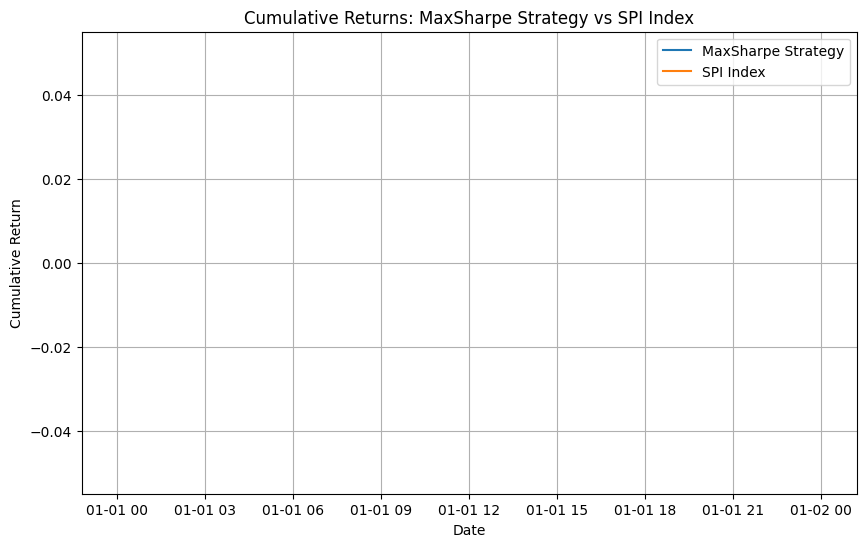

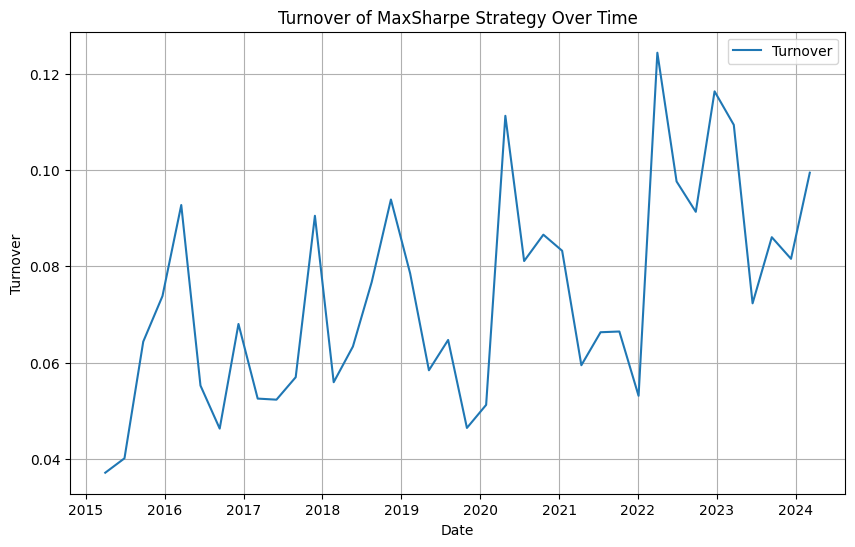

Annualized Turnover: 29.53%

Descriptive Performance Statistics:
               Metric MaxSharpe Strategy SPI Index
    Annualized Return              0.00%     3.35%
Annualized Volatility               nan%    14.01%
         Sharpe Ratio               nan%    23.90%
         Max Drawdown               nan%   -54.88%


In [25]:
# Get portfolio weights and rebalance dates
w_df = bt.strategy.get_weights_df()
rb_dates = pd.to_datetime(w_df.index)

# Compute asset returns between rebalance dates
prices = data.market_data
prices_wide = prices.groupby("date") ["price"].last().reset_index()
price_rb = prices_wide.reindex(rb_dates).ffill()
#asset_ret = (price_rb.shift(-1) / price_rb - 1).iloc[:-1]

# 3) Align assets between weights and returns 
common_assets = w_df.columns.astype(str).intersection(asset_ret.columns.astype(str))
w_period = w_df[common_assets].iloc[:-1]
asset_ret = asset_ret[common_assets]

# Calculate portfolio returns
port_ret = (w_period.values * asset_ret.values).sum(axis=1)
port_ret = pd.Series(port_ret, index=rb_dates[:-1])

# Compute turnover
turnover = w_df.diff().abs().sum(axis=1).iloc[1:]
turnover = pd.Series(turnover.values, index=rb_dates[1:])

# Apply transaction costs
fixed_cost = 0.01
variable_cost = 0.003
adjusted_returns = port_ret.copy()

for date in port_ret.index:
    if date in turnover.index:
        cost = fixed_cost + variable_cost * turnover.loc[date]
        adjusted_returns.loc[date] -= cost

# Calculate cumulative returns
cumulative_portfolio_returns = (1 + adjusted_returns).cumprod() - 1
cumulative_portfolio_returns.index = pd.to_datetime(cumulative_portfolio_returns.index)

# Calculate benchmark returns
bm_prices = data.bm_series.reindex(rb_dates).ffill()
bm_ret = (bm_prices.shift(-1) / bm_prices - 1).iloc[:-1].fillna(0)
cumulative_spi_returns = (1 + bm_ret).cumprod() - 1
cumulative_spi_returns.index = pd.to_datetime(cumulative_spi_returns.index)

# Plot cumulative returns
plt.figure(figsize=(10, 6))
plt.plot(cumulative_portfolio_returns.index, cumulative_portfolio_returns, label='MaxSharpe Strategy')
plt.plot(cumulative_spi_returns.index, cumulative_spi_returns, label='SPI Index')
plt.title('Cumulative Returns: MaxSharpe Strategy vs SPI Index')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
#plt.savefig('cumulative_returns.png')
plt.show()

# Plot turnover over time
plt.figure(figsize=(10, 6))
turnover_df = pd.Series(turnover, index=turnover.index)
turnover_df = turnover_df[turnover_df.index.isin(rb_dates)]
plt.plot(turnover_df.index, turnover_df, label='Turnover')
plt.title('Turnover of MaxSharpe Strategy Over Time')
plt.xlabel('Date')
plt.ylabel('Turnover')
plt.legend()
plt.grid(True)
#plt.savefig('turnover_plot.png')
plt.show()

# Compute and print annualized turnover
avg_turnover = np.mean(turnover.values)
rebalance_per_year = 252 / (21 * 3)  # Approx. 4 rebalances per year
annualized_turnover = avg_turnover * rebalance_per_year
print(f"Annualized Turnover: {annualized_turnover:.2%}")

# Descriptive performance statistics
stats = {
    'Metric': ['Annualized Return', 'Annualized Volatility', 'Sharpe Ratio', 'Max Drawdown'],
    'MaxSharpe Strategy': [],
    'SPI Index': []
}

# Helper functions for stats
def annualized_return(returns, periods_per_year=252):
    cum_return = (1 + returns).prod() - 1
    n_periods = len(returns)
    return (1 + cum_return) ** (periods_per_year / n_periods) - 1

def annualized_volatility(returns, periods_per_year=252):
    return returns.std() * np.sqrt(periods_per_year)

def sharpe_ratio(returns, periods_per_year=252, risk_free_rate=0):
    ann_ret = annualized_return(returns, periods_per_year)
    ann_vol = annualized_volatility(returns, periods_per_year)
    return (ann_ret - risk_free_rate) / ann_vol if ann_vol > 0 else np.nan

def max_drawdown(returns):
    cum_returns = (1 + returns).cumprod()
    peak = cum_returns.cummax()
    drawdown = (cum_returns - peak) / peak
    return drawdown.min()

# Calculate stats
for metric in stats['Metric']:
    if metric == 'Annualized Return':
        stats['MaxSharpe Strategy'].append(annualized_return(adjusted_returns))
        stats['SPI Index'].append(annualized_return(data.bm_series))
    elif metric == 'Annualized Volatility':
        stats['MaxSharpe Strategy'].append(annualized_volatility(adjusted_returns))
        stats['SPI Index'].append(annualized_volatility(data.bm_series))
    elif metric == 'Sharpe Ratio':
        stats['MaxSharpe Strategy'].append(sharpe_ratio(adjusted_returns))
        stats['SPI Index'].append(sharpe_ratio(data.bm_series))
    elif metric == 'Max Drawdown':
        stats['MaxSharpe Strategy'].append(max_drawdown(adjusted_returns))
        stats['SPI Index'].append(max_drawdown(data.bm_series))

# Create and print table
stats_df = pd.DataFrame(stats)
stats_df['MaxSharpe Strategy'] = stats_df['MaxSharpe Strategy'].apply(lambda x: f"{x:.2%}")
stats_df['SPI Index'] = stats_df['SPI Index'].apply(lambda x: f"{x:.2%}")
print("\nDescriptive Performance Statistics:")
print(stats_df.to_string(index=False))